# TWAP Analysis

## Purpose
Explore Reflexer TWAP. To change plot lengths, change `N_PLOTS`

### Number of minutes to plot

In [1]:
N_PLOTS = 15000

In [2]:
import time
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss

In [3]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 200 

### Import data

In [4]:
df_twap = pd.read_csv('twap.csv')
df_rai = pd.read_csv('rai_eth.csv')
df_eth = pd.read_csv('eth_usd.csv')

### Rename columns

In [5]:
df_twap = df_twap.rename(columns={"value": "twap_usd"})
df_rai = df_rai.rename(columns={"value": "rai_eth"})
df_eth = df_eth.rename(columns={"value": "eth_usd"})

### currentCoinMedianizerUpdates: RAI/USD values derived from RAI/ETH TWAP and Chainlink spot ETH/USD. 
Time: modified time

Source: the graph systemState.

In [6]:
df_twap.head(3)

,time,twap_usd,field
0,2021-05-28T00:03:02Z,3.025544,currentCoinMedianizerUpdate
1,2021-05-28T00:05:14Z,3.025544,currentCoinMedianizerUpdate
2,2021-05-28T00:16:11Z,3.025544,currentCoinMedianizerUpdate


### Spot RAI/ETH. 

Time: modified time

Source: The graph uniswapPair

In [7]:
df_rai.head(3)

,time,rai_eth,field
0,2021-05-28T00:03:02Z,0.001096,RAI/ETH price
1,2021-05-28T00:05:14Z,0.001100,RAI/ETH price
2,2021-05-28T00:21:06Z,0.001100,RAI/ETH price


### Spot ETH/USD from Coingecko. 

Time: API query time

In [8]:
df_eth.head(3)

,time,eth_usd,field
0,2021-05-28T00:01:27Z,2742.99,ETH/USD price
1,2021-05-28T00:03:30Z,2742.92,ETH/USD price
2,2021-05-28T00:05:32Z,2742.92,ETH/USD price


### Convert `time` str to datetime 

In [9]:
df_twap['time'] = pd.to_datetime(df_twap['time'], infer_datetime_format=True)
df_rai['time'] = pd.to_datetime(df_rai['time'], infer_datetime_format=True)
df_eth['time'] = pd.to_datetime(df_eth['time'], infer_datetime_format=True)

### Round each `time` to 1 min

In [10]:
df_twap['time_1m'] = df_twap['time'].dt.round('1min') 
df_rai['time_1m'] = df_rai['time'].dt.round('1min') 
df_eth['time_1m'] = df_eth['time'].dt.round('1min') 

### Rounding might have created some duplicates, so drop those

In [11]:
df_twap = df_twap.drop_duplicates(['time_1m']) 
df_rai = df_rai.drop_duplicates(['time_1m']) 
df_eth = df_eth.drop_duplicates(['time_1m']) 

### Forward fill every minute in between. This will allow joining since each df has a different set of timestamps

In [12]:
df_twap = df_twap.set_index('time_1m')
df_twap = df_twap.asfreq('1min', method='ffill')

df_rai = df_rai.set_index('time_1m')
df_rai = df_rai.asfreq('1min', method='ffill')

df_eth = df_eth.set_index('time_1m')
df_eth = df_eth.asfreq('1min', method='ffill')

### Join all dataframes

In [13]:
df_rai_eth = pd.merge(df_rai['rai_eth'], df_eth['eth_usd'], left_index=True, right_index=True)

### Calculate spot RAI/USD from spot RAI/ETH and spot ETH/USD

In [14]:
df_rai_eth['rai_usd'] = df_rai_eth['rai_eth'] * df_rai_eth['eth_usd']

In [15]:
all = pd.merge(df_rai_eth[['rai_eth', 'eth_usd', 'rai_usd']], df_twap['twap_usd'], left_index=True, right_index=True)

### Compare existing TWAP to spot RAI/USD

<AxesSubplot:xlabel='time_1m'>

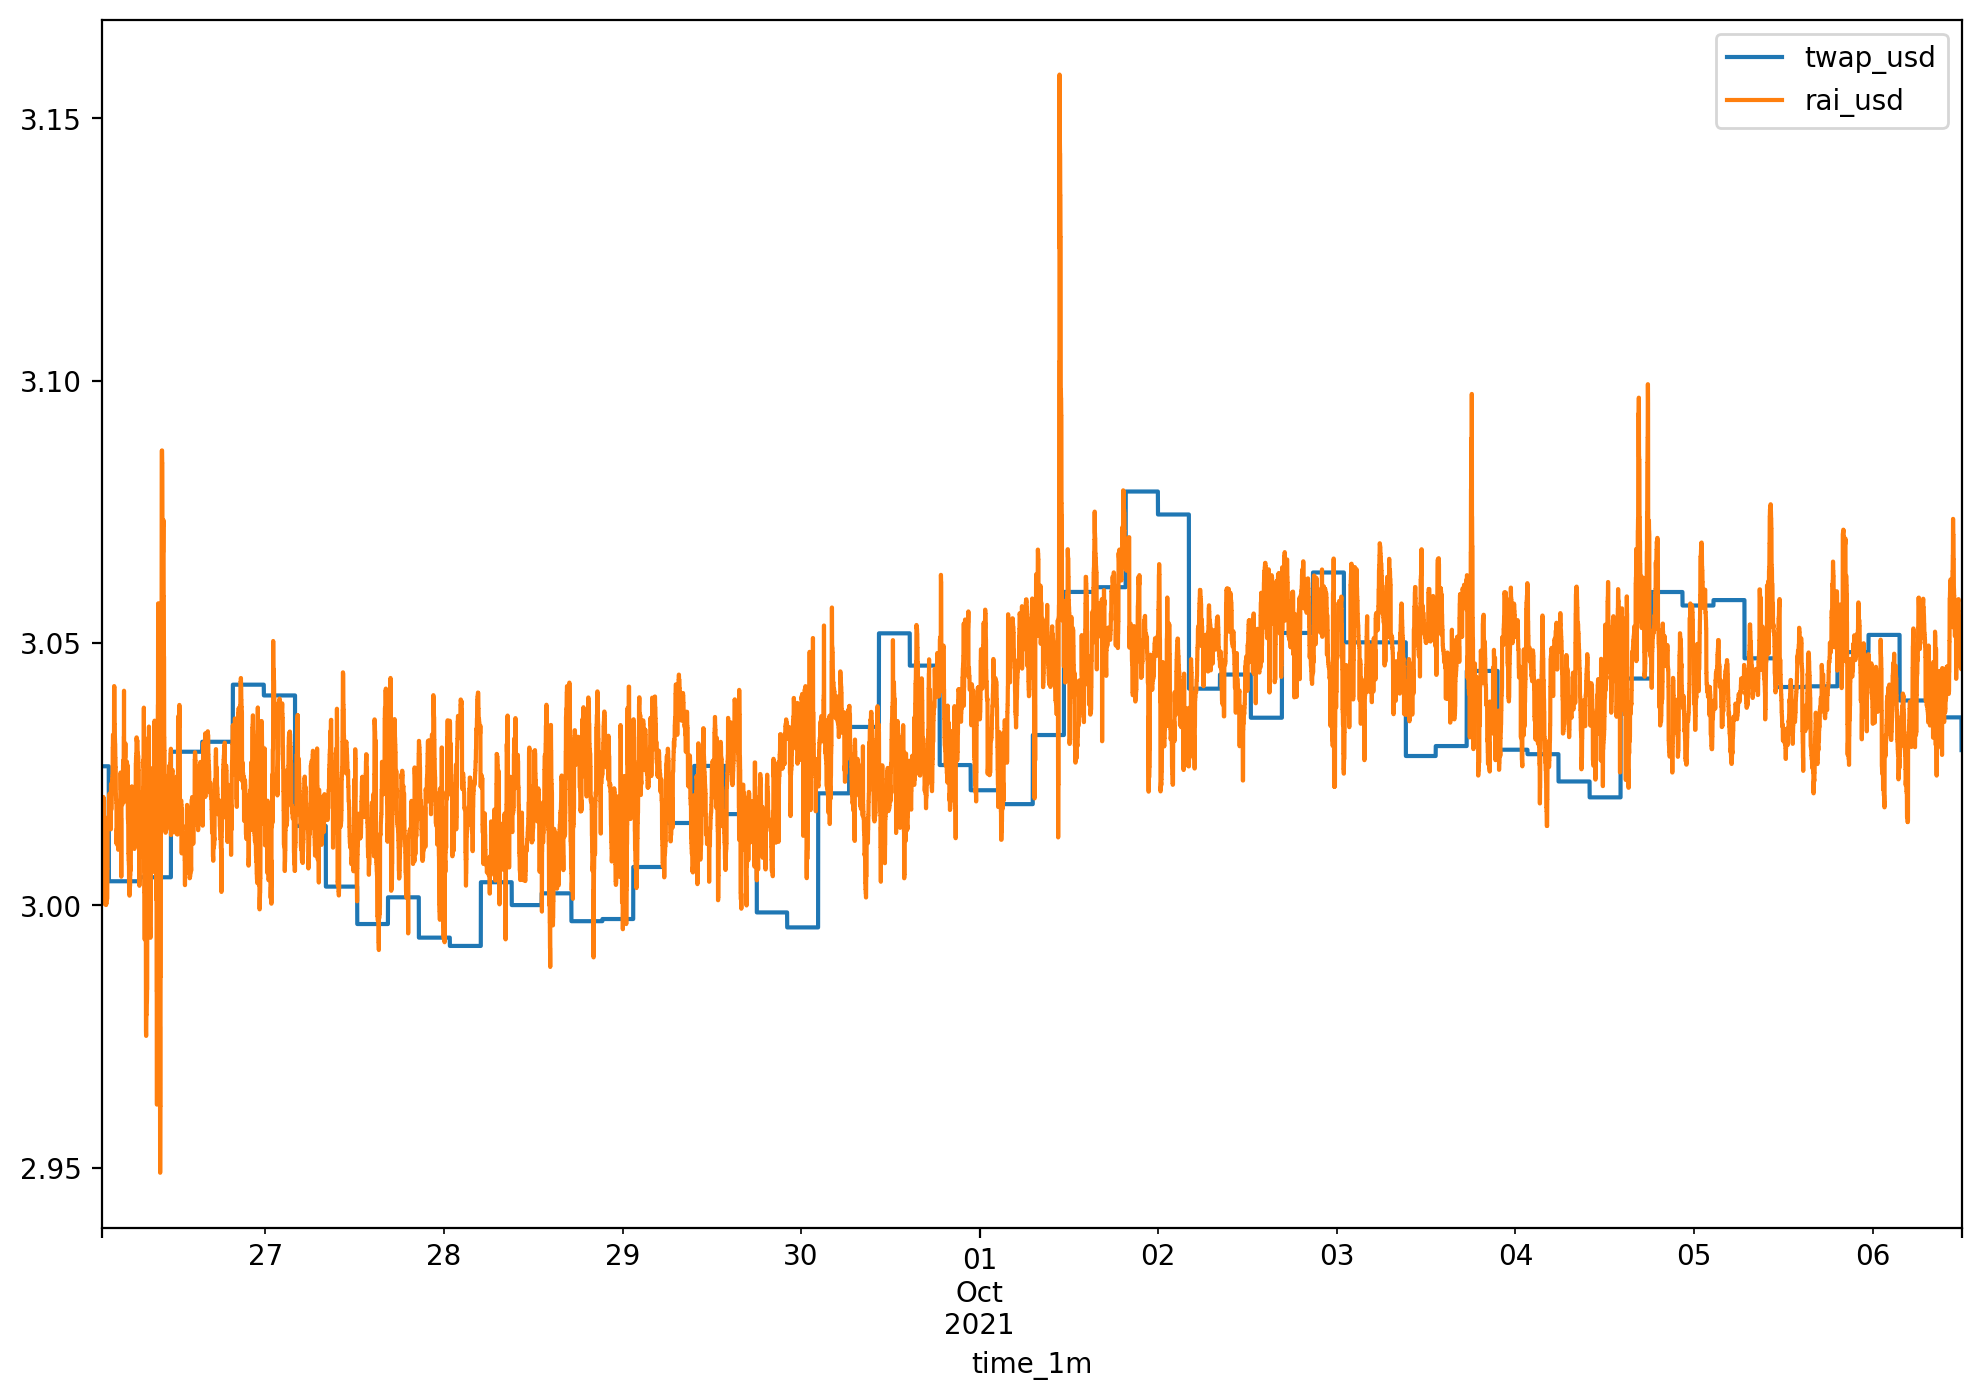

In [16]:
all[['twap_usd', 'rai_usd']][-N_PLOTS:].plot()

# Create 16H RAI/ETH TWAPs with 1, 4 and 8H sampling rates

In [17]:
df_rai_eth.head(10)

,rai_eth,eth_usd,rai_usd
time_1m,,,
2021-05-28 00:03:00,0.001096,2742.99,3.007601
2021-05-28 00:04:00,0.001096,2742.92,3.007524
2021-05-28 00:05:00,0.001100,2742.92,3.016369
2021-05-28 00:06:00,0.001100,2742.92,3.016369
2021-05-28 00:07:00,0.001100,2742.92,3.016369
2021-05-28 00:08:00,0.001100,2732.15,3.004525
2021-05-28 00:09:00,0.001100,2732.15,3.004525
2021-05-28 00:10:00,0.001100,2710.05,2.980222
2021-05-28 00:11:00,0.001100,2710.05,2.980222


### Get value every 1st, 4th, and 8th hour

In [18]:
df_rai_eth_8h = df_rai_eth.resample('8H').first()[['rai_eth', 'eth_usd']]
df_rai_eth_4h = df_rai_eth.resample('4H').first()[['rai_eth', 'eth_usd']]
df_rai_eth_1h = df_rai_eth.resample('1H').first()[['rai_eth', 'eth_usd']]

df_rai_eth_4h.head(10)

,rai_eth,eth_usd
time_1m,,
2021-05-28 00:00:00,0.001096,2742.99
2021-05-28 04:00:00,0.001110,2719.68
2021-05-28 08:00:00,0.001173,2570.08
2021-05-28 12:00:00,0.001230,2423.46
2021-05-28 16:00:00,0.001172,2561.46
2021-05-28 20:00:00,0.001195,2507.54
2021-05-29 00:00:00,0.001244,2430.35
2021-05-29 04:00:00,0.001194,2519.66
2021-05-29 08:00:00,0.001196,2498.82


### Calculate 16H RAI/ETH moving average

In [19]:
df_rai_eth_8h['twap_16_8'] = df_rai_eth_8h.rolling('16H')['rai_eth'].mean()
df_rai_eth_4h['twap_16_4'] = df_rai_eth_4h.rolling('16H')['rai_eth'].mean()
df_rai_eth_1h['twap_16_1'] = df_rai_eth_1h.rolling('16H')['rai_eth'].mean()

In [20]:
df_rai_eth_4h.head(5)

,rai_eth,eth_usd,twap_16_4
time_1m,,,
2021-05-28 00:00:00,0.001096,2742.99,0.001096
2021-05-28 04:00:00,0.001110,2719.68,0.001103
2021-05-28 08:00:00,0.001173,2570.08,0.001126
2021-05-28 12:00:00,0.001230,2423.46,0.001152
2021-05-28 16:00:00,0.001172,2561.46,0.001171


### Create new RAI/USD TWAPs by multiplying RAI/ETH TWAP with spot ETH/USD

In [21]:
df_rai_eth_8h['twap_16_8_usd'] = df_rai_eth_8h['twap_16_8'] * df_rai_eth_8h['eth_usd']
df_rai_eth_4h['twap_16_4_usd'] = df_rai_eth_4h['twap_16_4'] * df_rai_eth_4h['eth_usd']
df_rai_eth_1h['twap_16_1_usd'] = df_rai_eth_1h['twap_16_1'] * df_rai_eth_1h['eth_usd']

#df_rai_eth_5m['twap_16_5m_usd'] = df_rai_eth_5m['twap_16_5m'] * df_rai_eth_1h['eth_usd']

### Forward fill values every min

In [22]:
df_rai_eth_8h = df_rai_eth_8h.asfreq('1min', method='ffill')
df_rai_eth_4h = df_rai_eth_4h.asfreq('1min', method='ffill')
df_rai_eth_1h = df_rai_eth_1h.asfreq('1min', method='ffill')


In [23]:
df_rai_eth_4h.head(5)

,rai_eth,eth_usd,twap_16_4,twap_16_4_usd
time_1m,,,,
2021-05-28 00:00:00,0.001096,2742.99,0.001096,3.007601
2021-05-28 00:01:00,0.001096,2742.99,0.001096,3.007601
2021-05-28 00:02:00,0.001096,2742.99,0.001096,3.007601
2021-05-28 00:03:00,0.001096,2742.99,0.001096,3.007601
2021-05-28 00:04:00,0.001096,2742.99,0.001096,3.007601


### Compare RAI/ETH Twap with RAI/ETH spot

<AxesSubplot:xlabel='time_1m'>

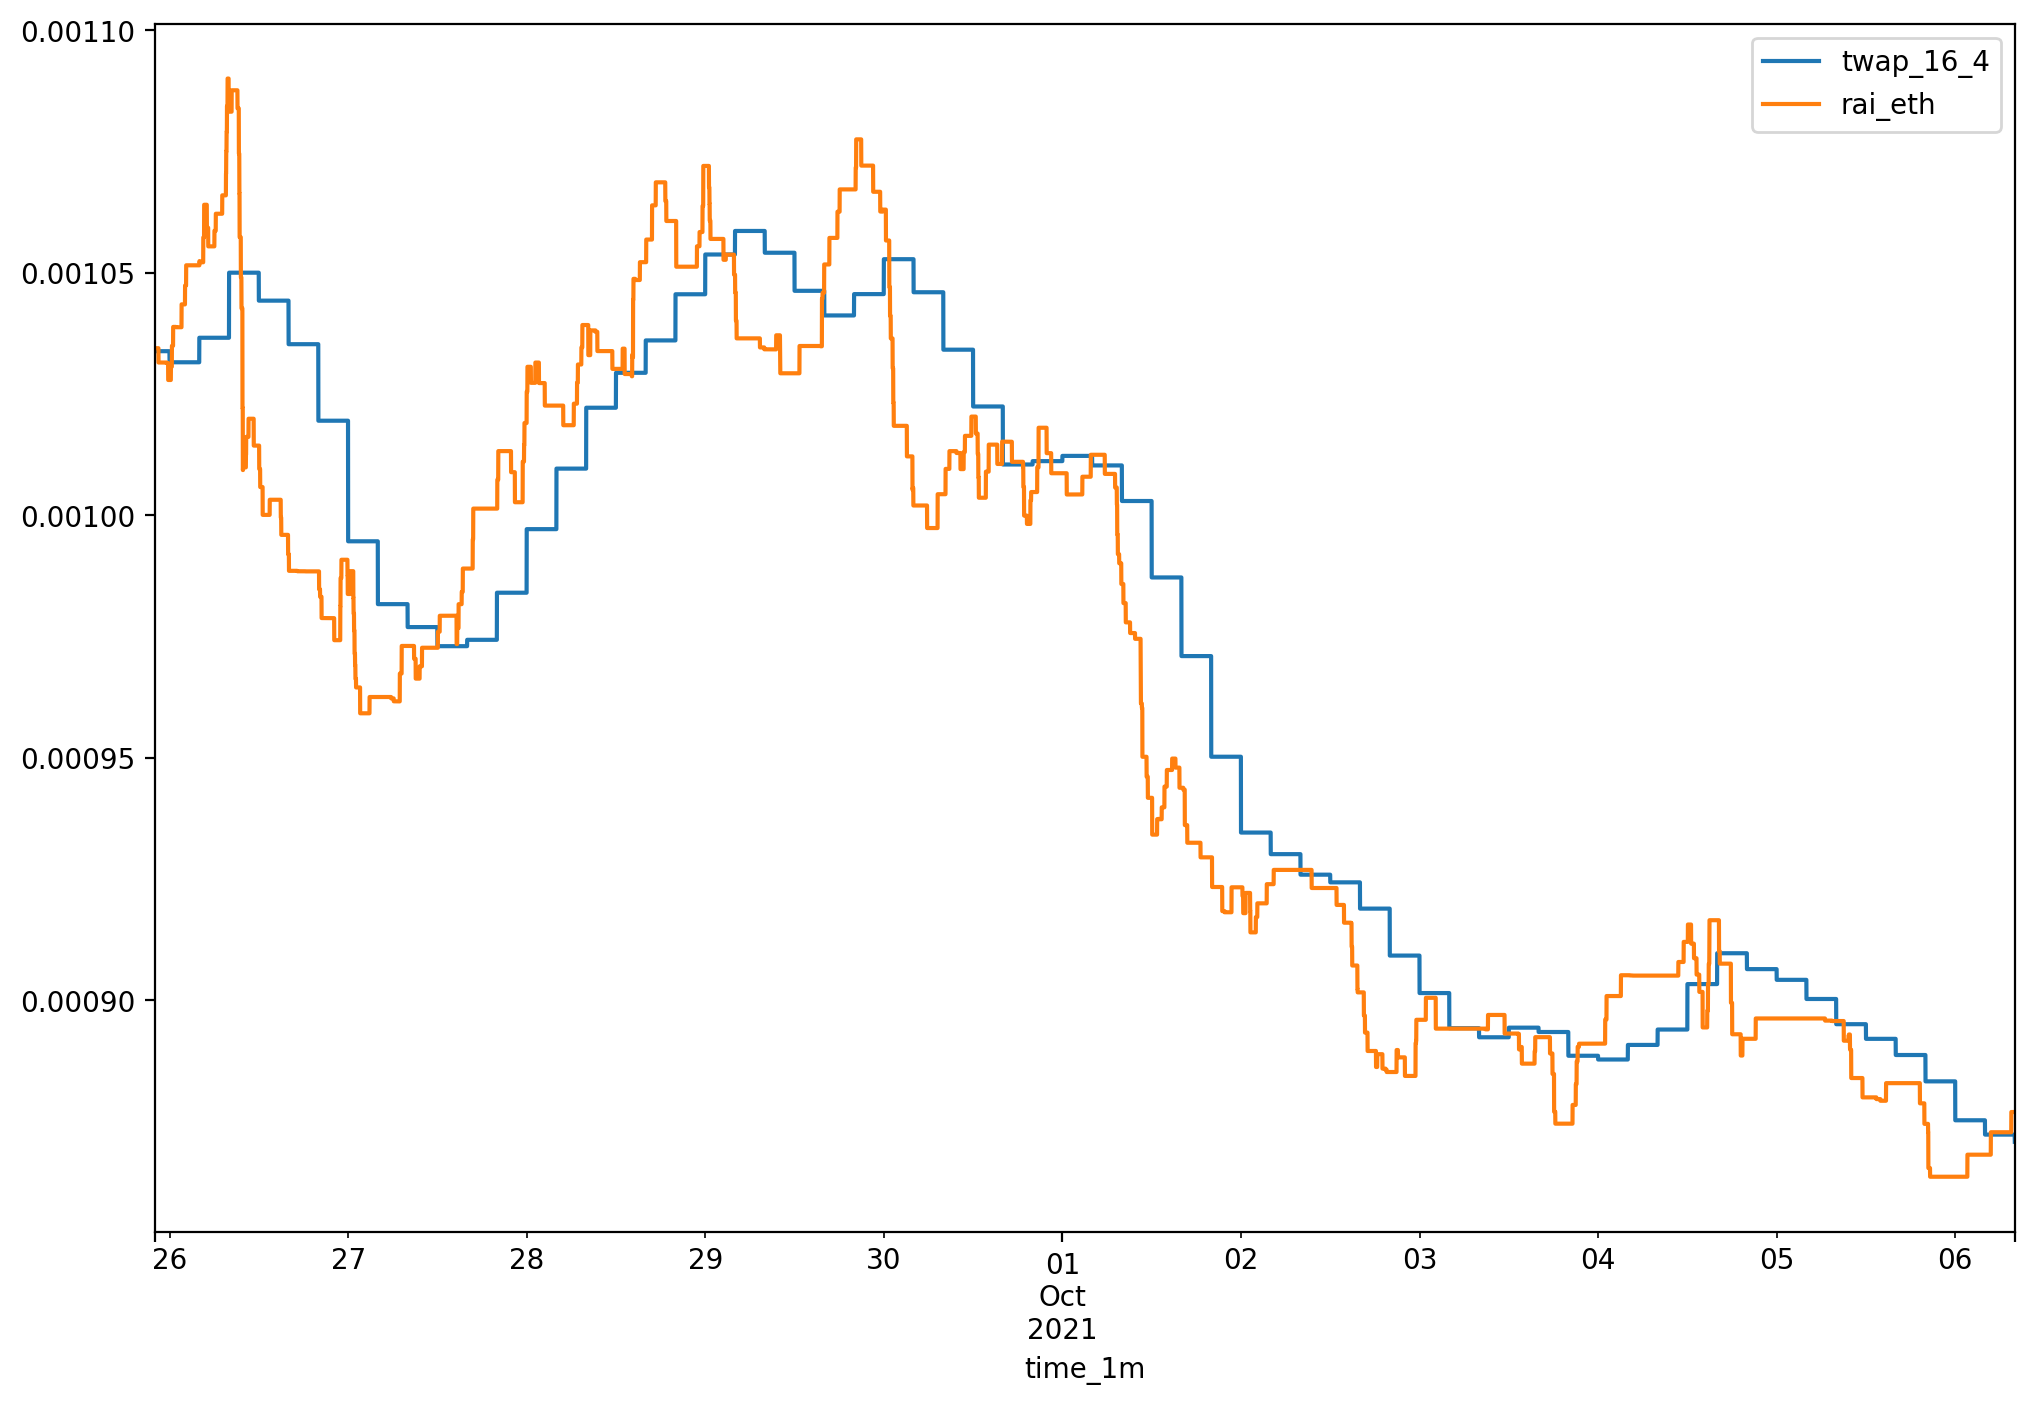

In [24]:
df_twap = pd.merge(df_rai_eth_4h[['twap_16_4']], df_rai_eth[['rai_eth']], left_index=True, right_index=True)
df_twap[-N_PLOTS:].plot()

### Compare ETH/USD used for TWAP with spot ETH/USD

<AxesSubplot:xlabel='time_1m'>

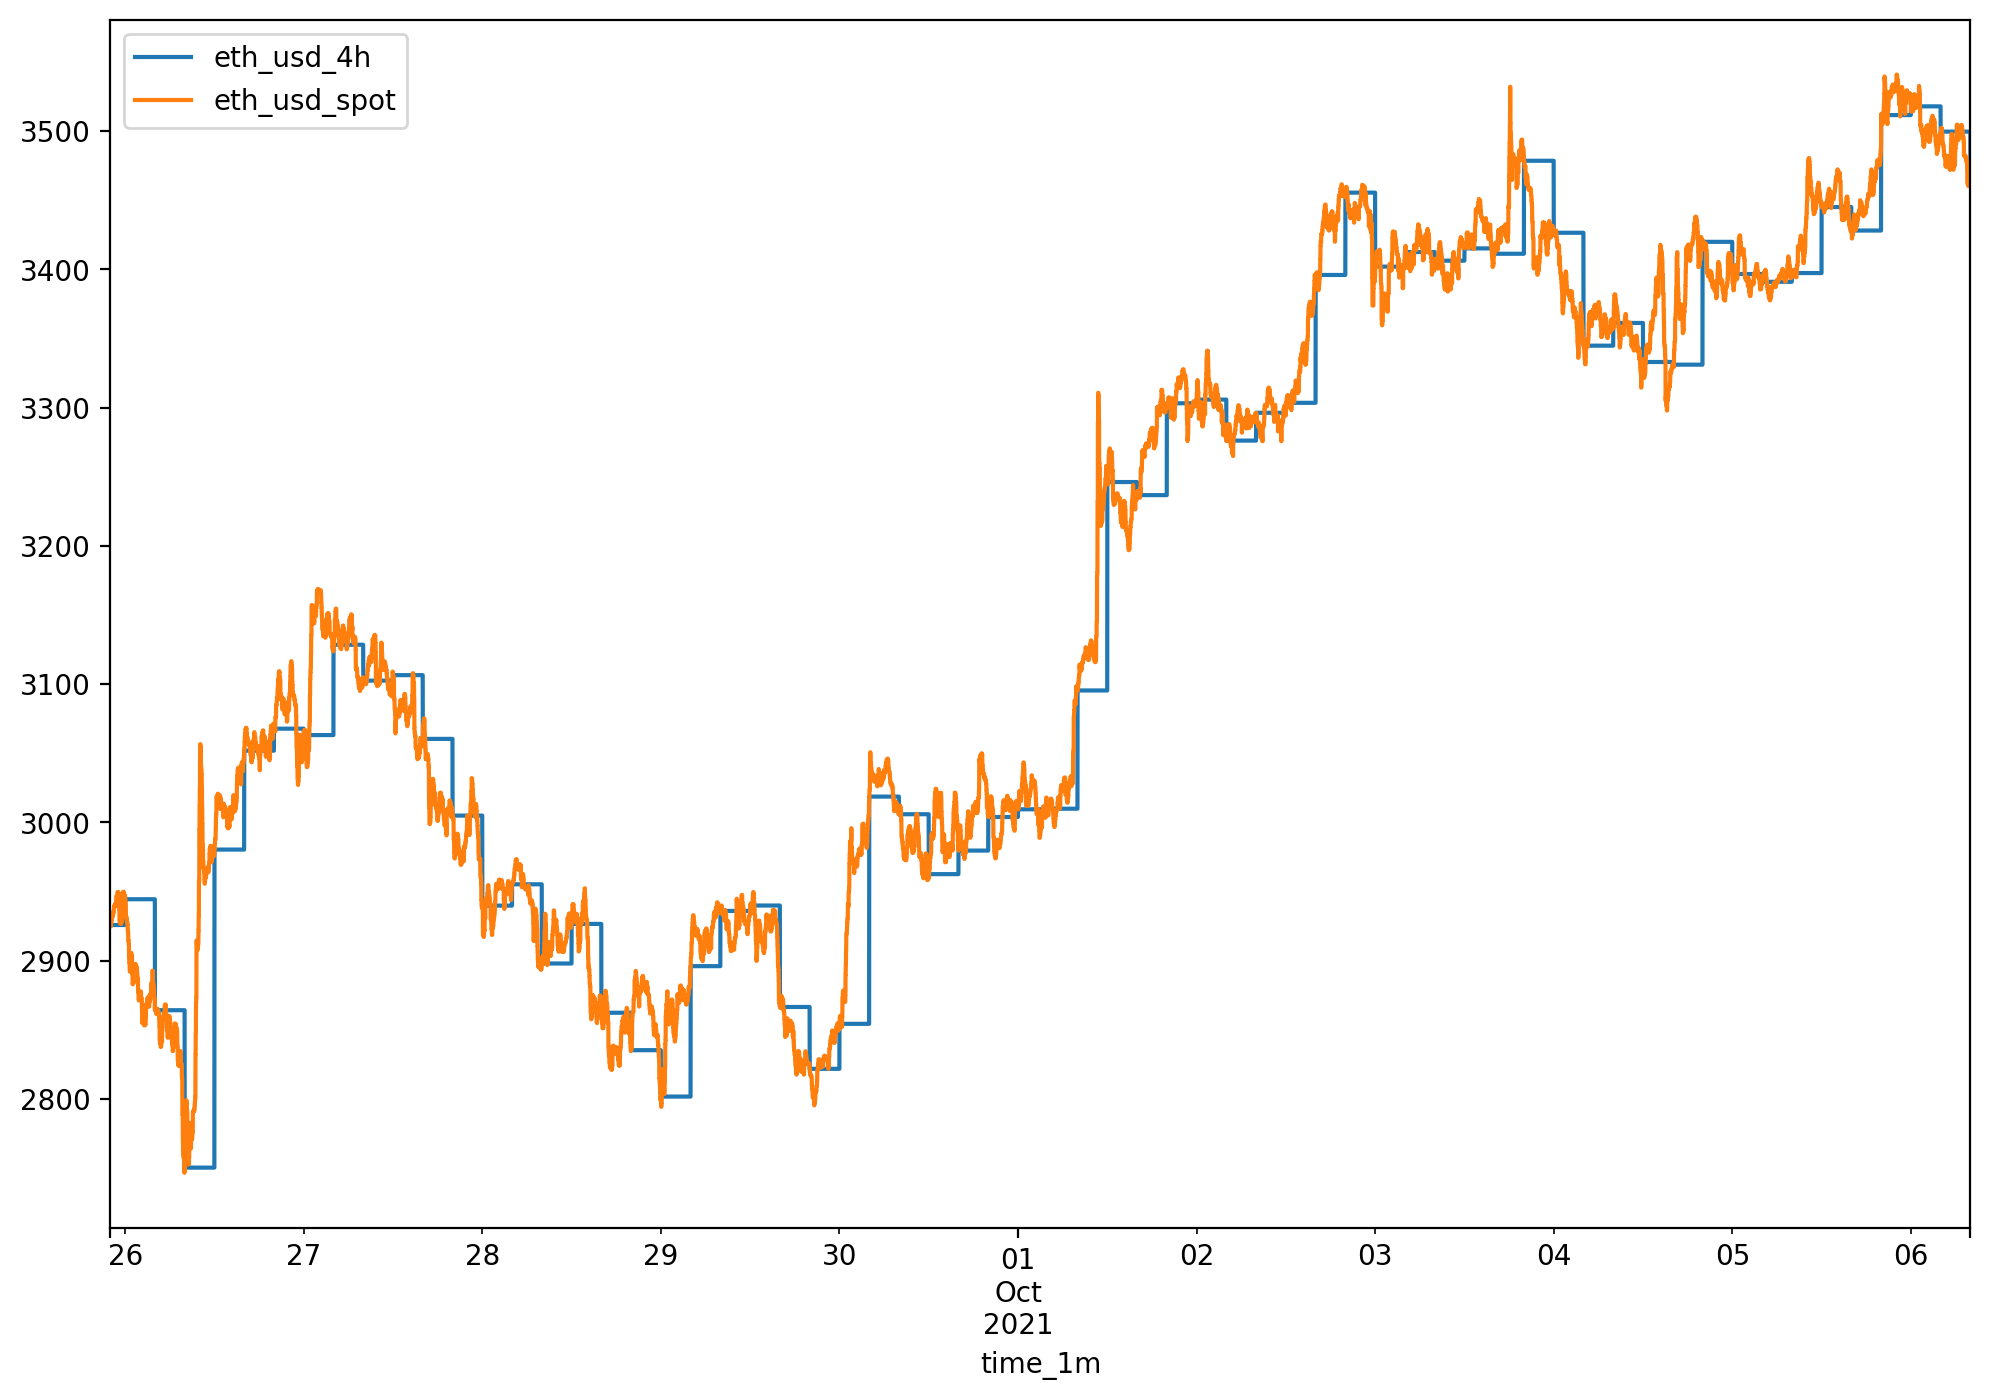

In [25]:
df = pd.merge(df_rai_eth_4h['eth_usd'], df_rai_eth['eth_usd'], suffixes=('_4h', '_spot'), left_index=True, right_index=True)
df[-N_PLOTS:].plot()

### Compare RAI/USD Twap with RAI/USD spot

<AxesSubplot:xlabel='time_1m'>

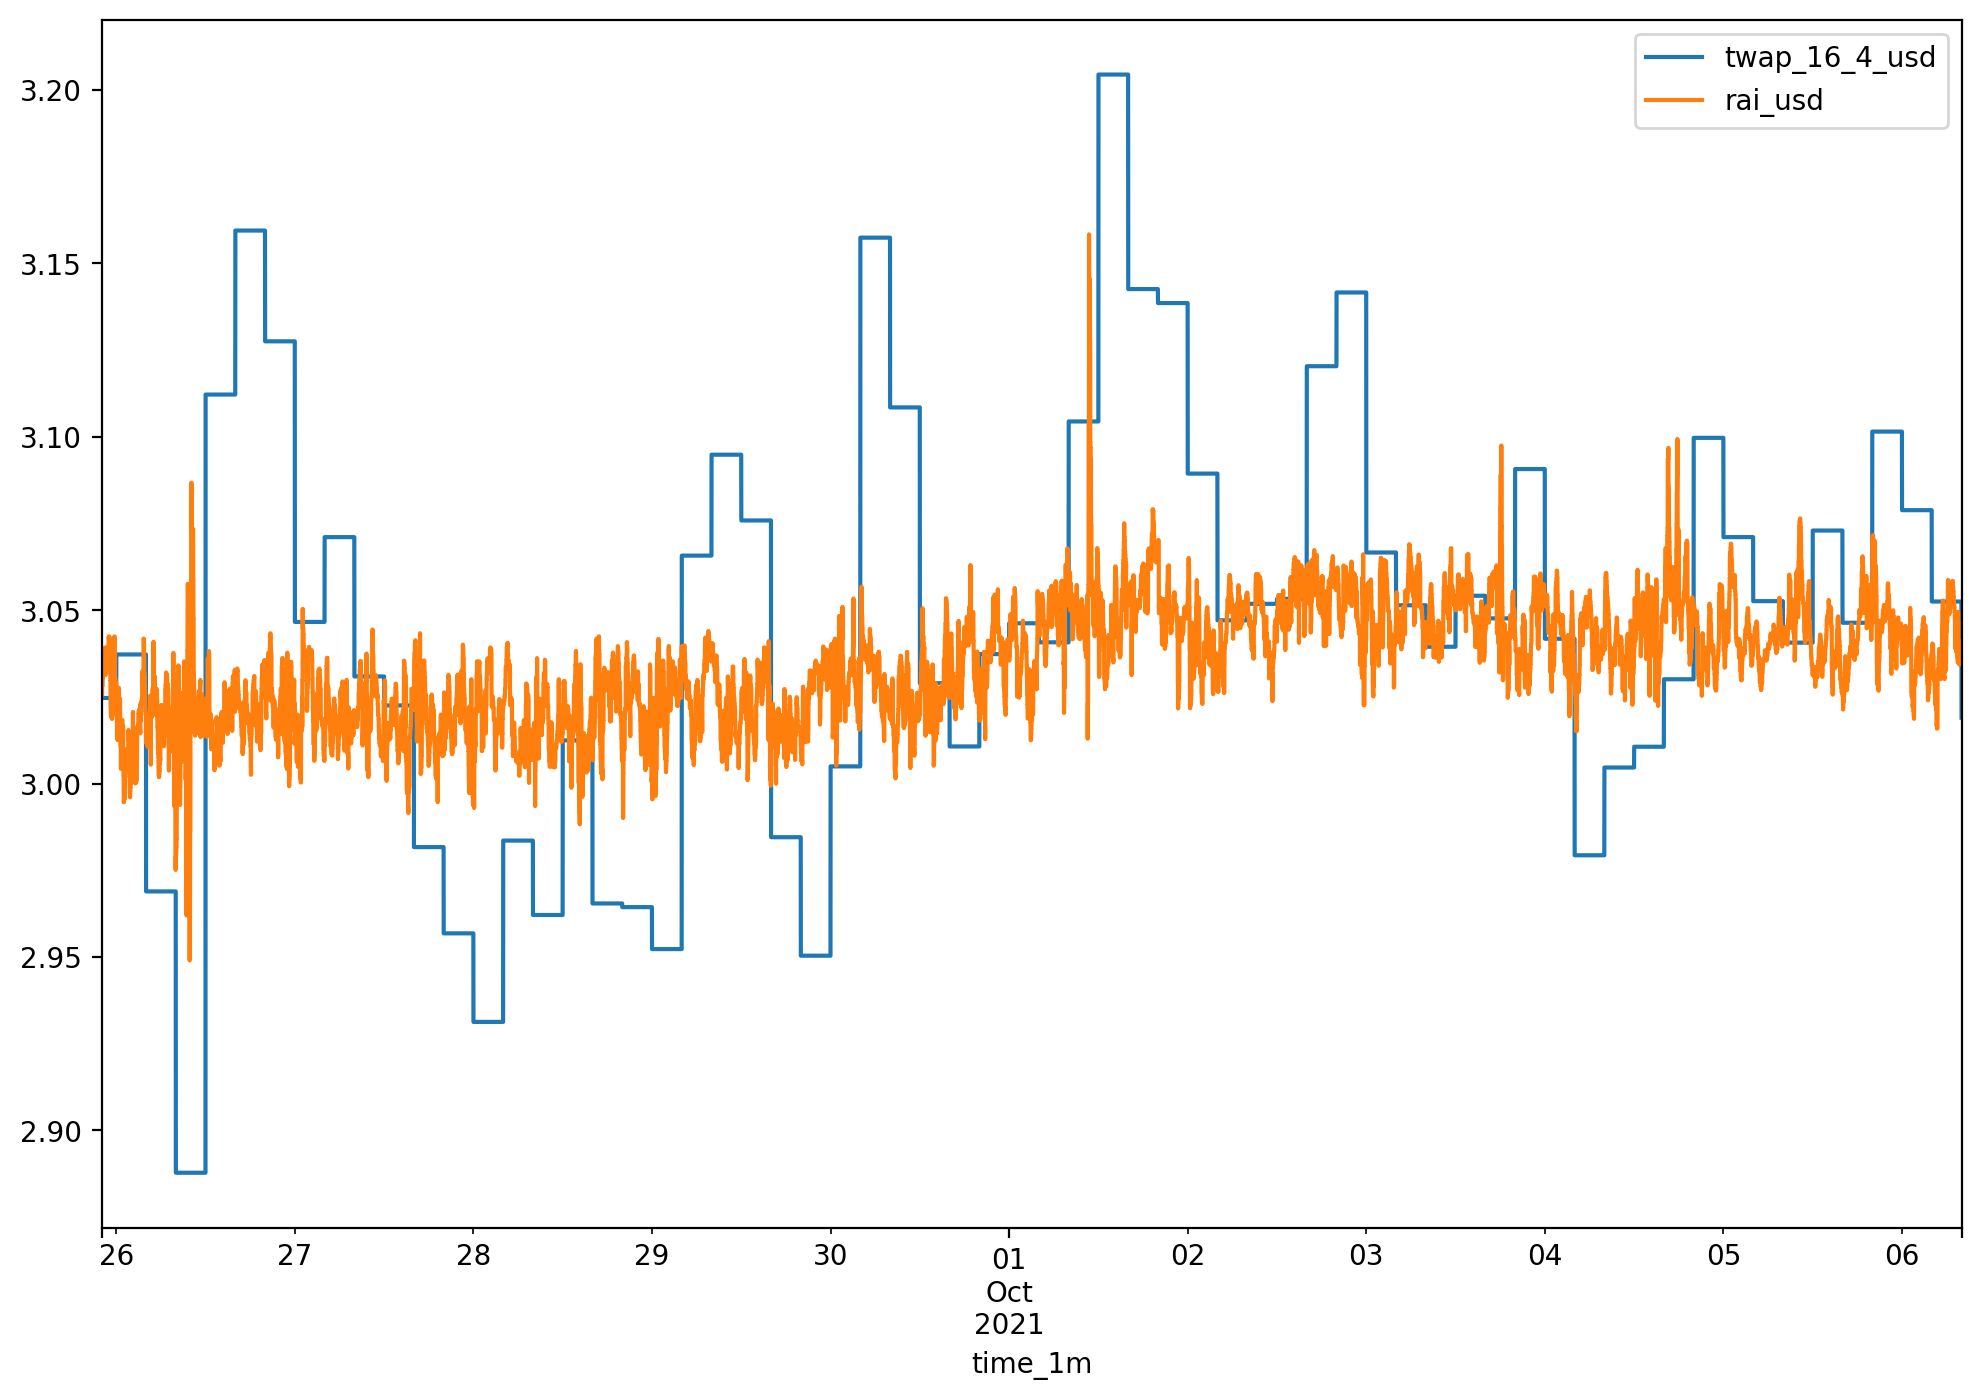

In [26]:
df = pd.merge(df_rai_eth_4h[['twap_16_4_usd']], df_rai_eth[['rai_usd']], left_index=True, right_index=True)
df[-N_PLOTS:].plot()

### Compare different period 16H TWAPs

<AxesSubplot:xlabel='time_1m'>

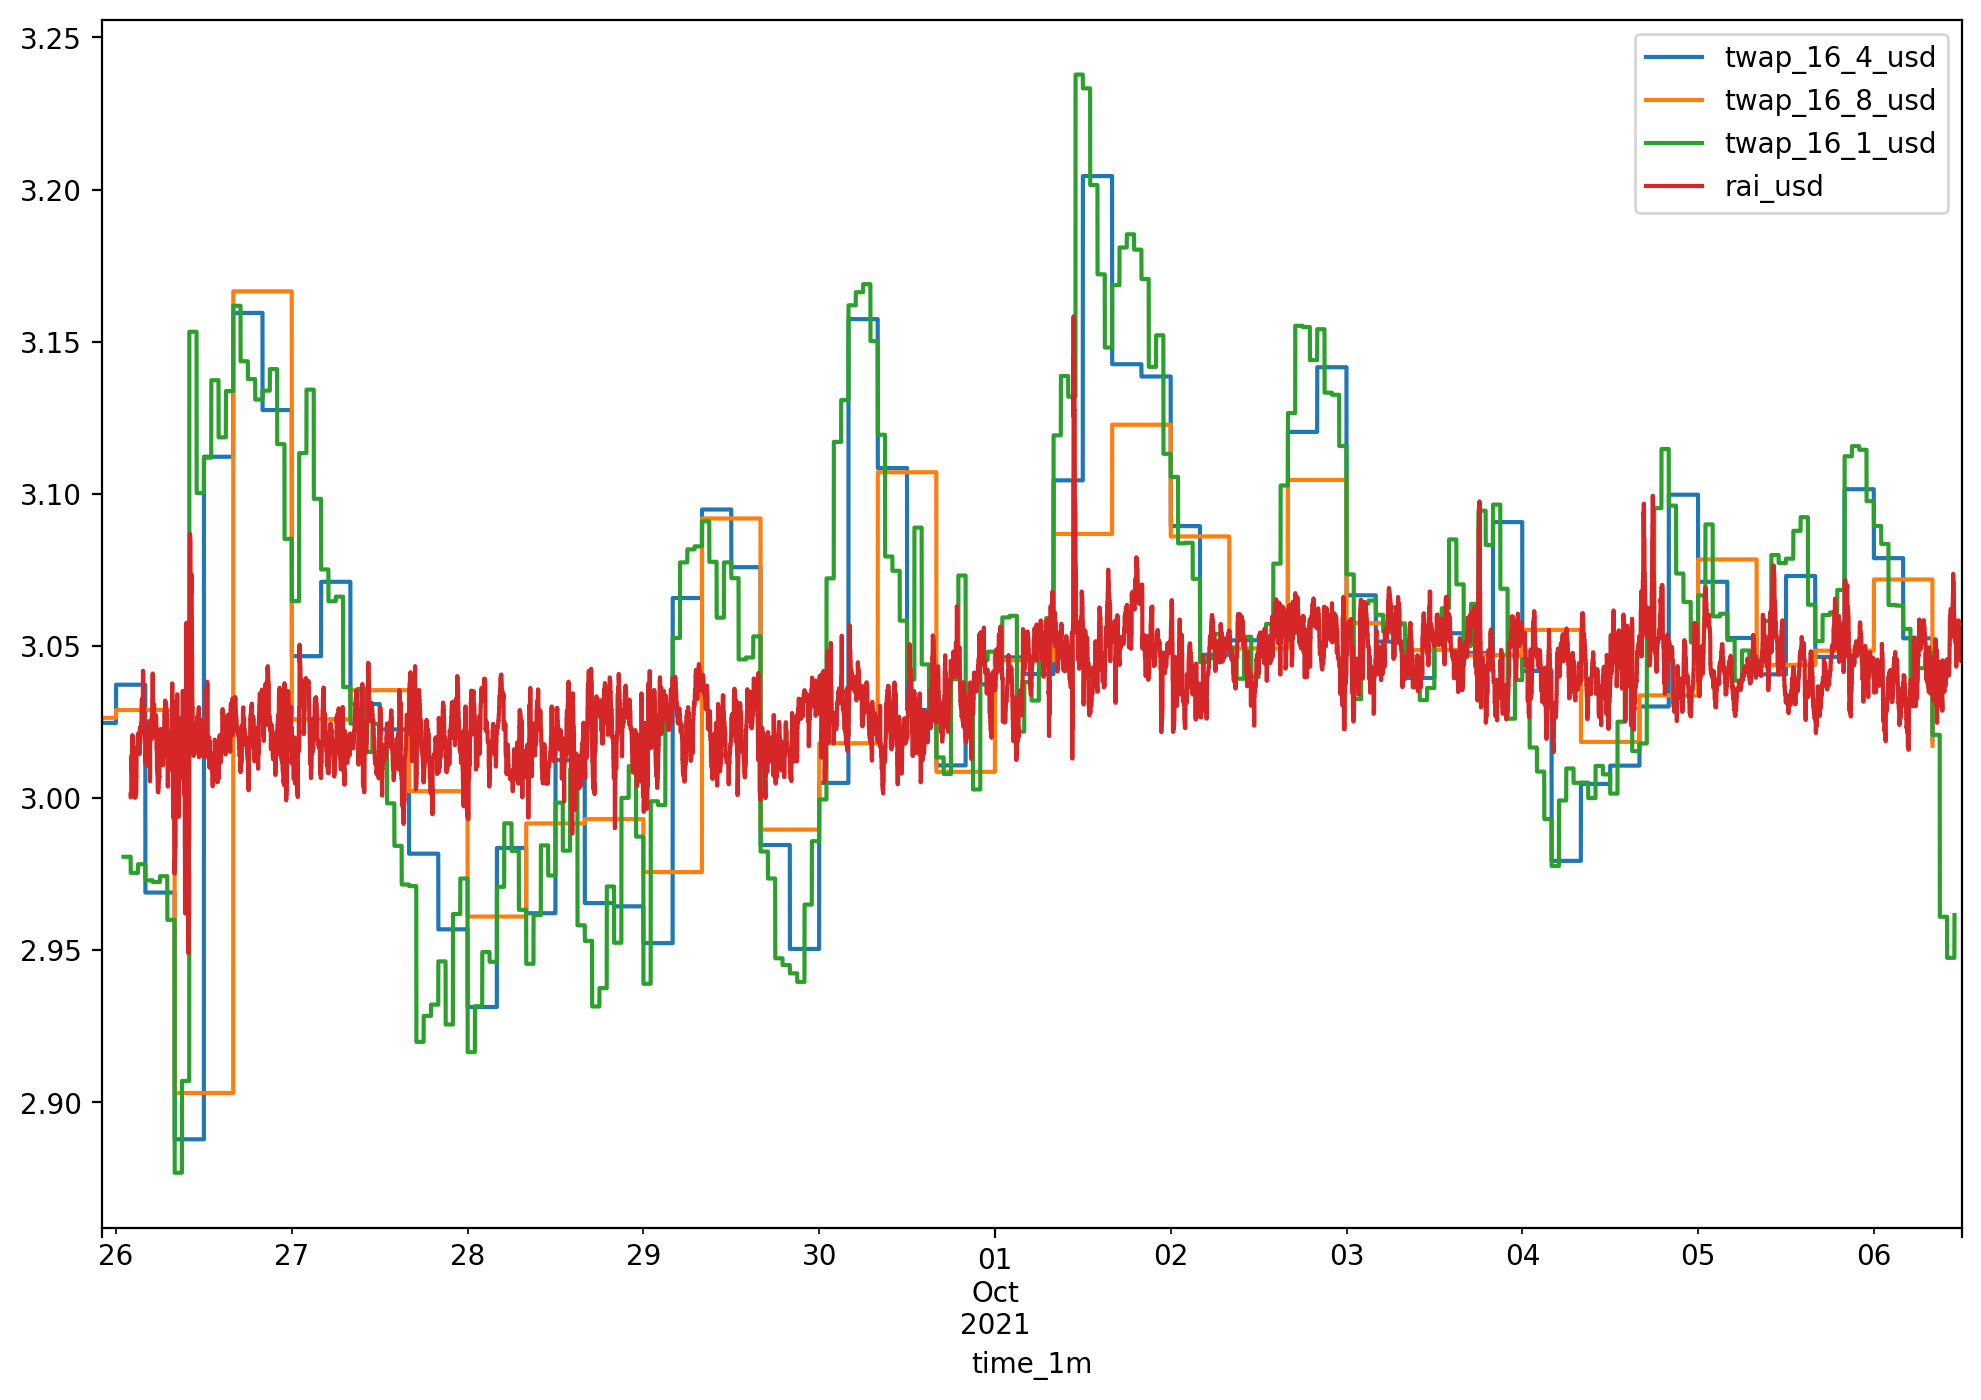

In [27]:
ax = df_rai_eth_4h[['twap_16_4_usd']][-N_PLOTS:].plot()
df_rai_eth_8h[['twap_16_8_usd']][-N_PLOTS:].plot(ax=ax)
df_rai_eth_1h[['twap_16_1_usd']][-N_PLOTS:].plot(ax=ax)
df_rai_eth[['rai_usd']][-N_PLOTS:].plot(ax=ax)